## Heatmap for feature exclusion

### Parse all the data into a nice tidy dataframe

In [2]:
cd ../../

/data/nasif12/home_if12/avsec/projects-work/code_spline_trans


In [211]:
import pandas as pd
dt = pd.read_table("data/eclip/raw/metadata.tsv")
RBPS = pd.Series([x[0] for x in dt[dt.Assembly == "GRCh38"]["Experiment target"].str.split("-")]).unique()
assert len(RBPS) == 112

In [212]:
ROOT_DIR = "data/eclip"
PROC_DIR = ROOT_DIR + "/processed"
EXP = "DeepNN_scalar_position_ext_gam"
glob_pattern = PROC_DIR + "/feature_exclusion_exp/results/{rbp_name}/{exp}-excl-{fset}.json"
glob_pattern_deepcis = "/s/project/deepcis/encode/eclip/processed/feature_exclusion_exp/results/{rbp_name}/{exp}-excl-{fset}.json"

In [213]:
from snakemake.utils import listfiles
from concise.utils.helper import read_json
from concise.hyopt import _flatten_dict

In [214]:
def load_data(fname, args):
    start = _flatten_dict(read_json(fname), separator=".")
    return {**start, **dict(args)}

In [298]:
res = pd.DataFrame.from_records([load_data(fname, args) for fname, args in listfiles(glob_pattern)])

In [303]:
res.fset.unique()
pos_categories_all = ['tss,gene_start', 'gene_start', "tss", "start_codon", 'exon_intron', 
                      'intron_exon', 'stop_codon', 'polya', 'gene_end', 'polya,gene_end']
pos_categories = ['gene_start', "tss", "start_codon", 'exon_intron', 
                  'intron_exon', 'stop_codon', 'polya', 'gene_end']

In [304]:
res_subset = res[res.fset.isin(pos_categories)]
res_subset["fset"] = pd.Categorical(res_subset.fset, categories=pos_categories)

In [306]:
df = res_subset[["parsed_args.rbp", "fset", "eval_test.auprc"]]
df["fset"] = df.fset.str.replace(",", ", ")

## Scale by RBP

### Add the baseline performance row

In [2]:
import os
import concise.eval_metrics as cem
import seaborn as sns

/home/avsec/bin/anaconda3/lib/python3.6/importlib/_bootstrap.py:205: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


In [310]:
dfp = df.pivot("fset", "parsed_args.rbp", "eval_test.auprc")

In [314]:
from tqdm import tqdm

In [315]:
def load_perf(dir_root, rbp_list, exp_list, verbose=False):
    dt_list = []
    dt_pred_list = []
    for rbp in rbp_list:
        for exp in exp_list:
            
            path = "{root}/processed/predictions/{rbp}/{method}.csv".format(root=dir_root, rbp=rbp, method=exp)
            if os.path.exists(path):
                if verbose:
                    print(path)
                dt = pd.read_csv(path)
                del dt["Unnamed: 0"]
                dt["rbp"] = rbp
                dt["method"] = exp               
                
                auc = cem.auc(dt["y_true"], dt["y_pred"])
                auprc = cem.auprc(dt["y_true"], dt["y_pred"])
                # TODO - add random auc and auprc
                auc_random = cem.auc(dt["y_true"], dt["y_true"].sample(frac=1, replace=False))
                auprc_random = cem.auprc(dt["y_true"], dt["y_true"].sample(frac=1, replace=False))
                #auc_random = auc
                #auprc_random = auprc
                
                dtm = pd.DataFrame({"rbp": [rbp], "method": [exp],
                                    "auprc": [auprc], "auc": [auc], 
                                    "auprc_random": [auprc_random], "auc_random": [auc_random],
                                    })
                dt_list.append(dtm)
                #dt_pred_list.append(dt)
    dt_test = pd.concat(dt_list)
    #dt_pred_test = pd.concat(dt_pred_list)
    dtt = dt_test.set_index(["rbp", "method"]).unstack()
    return dtt

In [316]:
RBP_ALL = list(dfp.columns)

seq_w_dist_df = load_perf(ROOT_DIR, RBP_ALL, ["DeepNN_scalar_position_ext_gam"])
seq_w_dist = seq_w_dist_df["auprc"]["DeepNN_scalar_position_ext_gam"]
seq_only = load_perf(ROOT_DIR, RBP_ALL, ["DeepNN_ext"])["auprc"]["DeepNN_ext"]
random_auprc = seq_w_dist_df["auprc_random"].DeepNN_scalar_position_ext_gam

In [318]:
dfp_sub = dfp

In [319]:
dfp_sub_transf = dfp_sub.sub(seq_only).div(seq_w_dist - seq_only)
dfp_sub_transf[dfp_sub_transf > 1] = 1
dfp_sub_transf[dfp_sub_transf < 0] = 0

In [320]:
#st_vs_seq_only = (seq_w_dist - seq_only) / (seq_w_dist - random_auprc)

In [321]:
st_vs_seq_only = (seq_w_dist - seq_only) / (seq_only - random_auprc)

In [322]:
rbp = "HNRNPUL1"

In [323]:
seq_only[[rbp]]

rbp
HNRNPUL1    0.5398
Name: DeepNN_ext, dtype: float64

In [324]:
seq_w_dist[[rbp]]

rbp
HNRNPUL1    0.6496
Name: DeepNN_scalar_position_ext_gam, dtype: float64

In [325]:
dfp_sub[[rbp]]

parsed_args.rbp,HNRNPUL1
fset,
exon_intron,0.5474
gene_end,0.5674
gene_start,0.5794
...,...
start_codon,0.5748
stop_codon,0.5628
tss,0.5460


In [326]:
# Why are these all worse?

In [327]:
from concise.hyopt import CMongoTrials, get_model, get_data

In [328]:
trials = CMongoTrials(db_name="RBP__Eclip_p", exp_name="DeepNN_scalar_position_ext_gam_" + rbp)
trials.as_df().sort_values("eval.auprc", ascending=False)

2017-10-12 11:53:21,974 [INFO] PROTOCOL mongo
2017-10-12 11:53:21,977 [INFO] USERNAME None
2017-10-12 11:53:21,979 [INFO] HOSTNAME ouga03
2017-10-12 11:53:21,981 [INFO] PORT 1234
2017-10-12 11:53:21,983 [INFO] PATH /RBP__Eclip_p/jobs
2017-10-12 11:53:21,985 [INFO] DB RBP__Eclip_p
2017-10-12 11:53:21,987 [INFO] COLLECTION jobs
2017-10-12 11:53:21,989 [INFO] PASS None


,tid,loss,status,eval.acc,eval.auc,eval.auprc,eval.loss,name.data,name.model,name.optim_metric,name.optim_metric_mode,param.data.n_bases,param.data.pos_class_weight,param.data.rbp_name,param.data.test_chr,param.data.valid_chr,param.fit.batch_size,param.fit.early_stop_monitor,param.fit.epochs,param.fit.patience,param.fit.use_weight,param.model.activation,param.model.dropout_rate,param.model.external_pos.as_track,param.model.external_pos.feat_names,param.model.external_pos.type,param.model.external_pos.units,param.model.filters,param.model.internal_pos.name,param.model.internal_pos.pool_size,param.model.kernel_size,param.model.lr,param.model.use_batchnorm,path.model,path.results,time.duration.dataload,time.duration.total,time.duration.training,time.end,time.start,n_epoch
0,1526,-0.5975,ok,0.8336,0.8296,0.5975,0.3885,data_extended,model,auprc,auprc,20,1.0,HNRNPUL1,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.5666,False,"[tss, polya, exon_int...",gam,1,16,strided_maxpool,4,11,0.0015,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,0.0459,48.7215,48.6755,2017-09-30 04:24:31.3...,2017-09-30 04:23:42.6...,34
11,2098,-0.5955,ok,0.8322,0.8250,0.5955,0.3938,data_extended,model,auprc,auprc,30,1.0,HNRNPUL1,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.2425,False,"[tss, polya, exon_int...",gam,1,16,strided_maxpool,4,11,0.0092,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,0.0390,20.4067,20.3678,2017-09-30 07:01:54.2...,2017-09-30 07:01:33.8...,12
2,1630,-0.5938,ok,0.8295,0.8266,0.5938,0.3895,data_extended,model,auprc,auprc,30,1.0,HNRNPUL1,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.6649,False,"[tss, polya, exon_int...",gam,1,16,strided_maxpool,4,11,0.0029,False,/s/project/deepcis/hy...,/s/project/deepcis/hy...,0.5014,52.3579,51.8565,2017-09-30 04:51:13.5...,2017-09-30 04:50:21.1...,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19,2495,-0.5097,ok,0.8113,0.7813,0.5097,0.4468,data_extended,model,auprc,auprc,20,1.0,HNRNPUL1,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.1764,False,"[tss, polya, exon_int...",gam,1,16,strided_maxpool,4,11,0.0008,True,/s/project/deepcis/hy...,/s/project/deepcis/hy...,0.0362,122.3087,122.2725,2017-09-30 08:44:28.3...,2017-09-30 08:42:26.0...,12
13,2202,-0.4368,ok,0.7890,0.7353,0.4368,0.4919,data_extended,model,auprc,auprc,20,1.0,HNRNPUL1,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.0099,False,"[tss, polya, exon_int...",gam,1,16,strided_maxpool,4,11,0.0047,True,/s/project/deepcis/hy...,/s/project/deepcis/hy...,0.0421,80.0604,80.0183,2017-09-30 07:26:27.0...,2017-09-30 07:25:07.0...,6
3,1682,-0.4241,ok,0.7890,0.7400,0.4241,0.4834,data_extended,model,auprc,auprc,20,1.0,HNRNPUL1,"[2, 4, 6, 8, 10]","[1, 3]",128,val_loss,150,5,False,relu,0.0877,False,"[tss, polya, exon_int...",gam,1,16,strided_maxpool,4,11,0.0023,True,/s/project/deepcis/hy...,/s/project/deepcis/hy...,0.0490,69.5662,69.5173,2017-09-30 05:06:36.4...,2017-09-30 05:05:26.8...,6


In [329]:
m = trials.load_model(trials.best_trial_tid())

In [330]:
param = trials.get_param(trials.best_trial_tid())

## Nice heatmap

In [ ]:
from sklearn.preprocessing import minmax_scale

from matplotlib.colors import rgb2hex

color_vector = sns.cubehelix_palette(as_cmap=True)
colors_seq_w_dist = color_vector(minmax_scale(seq_w_dist))
colors_seq_only = zcolor_vector(minmax_scale(seq_only))
colors_delta = color_vector(minmax_scale(seq_w_dist - seq_only))
sort_idx = np.argsort(-seq_w_dist + seq_only)

/opt/modules/i12g/anaconda/3-4.1.1/lib/python3.5/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


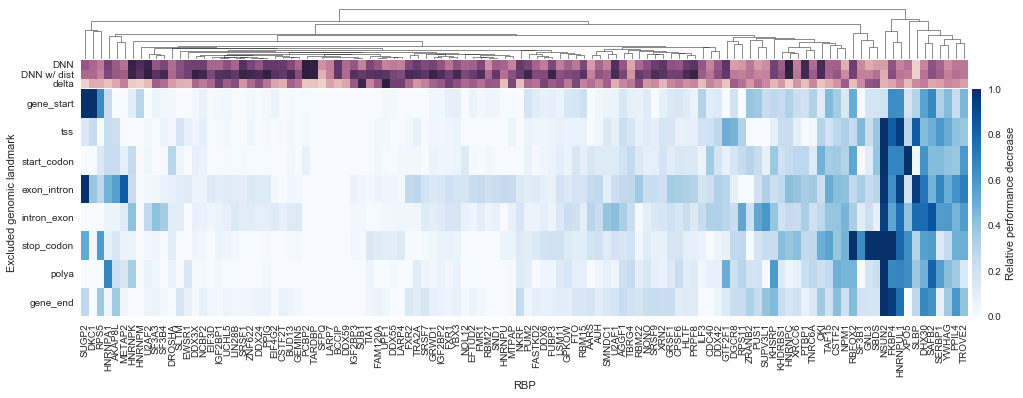

In [353]:
cg = sns.clustermap(1-dfp_sub_transf.loc[pos_categories], figsize=(20,5),
                    col_colors=np.stack([colors_seq_only, #bottom
                                         colors_seq_w_dist, # top
                                         colors_delta]),
                    cmap="Blues", row_cluster=False)
res = plt.setp(cg.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
cg.ax_row_dendrogram.clear()
col = cg.cax.get_position()
col = cg.cax.get_position()

cg.ax_heatmap.yaxis.set_label_position("left")
cg.ax_heatmap.yaxis.set_ticks_position("left")
cg.ax_heatmap.set_ylabel("Excluded genomic landmark")
cg.ax_heatmap.set_xlabel("RBP")
cg.cax.set_ylabel("Relative performance decrease")
#cg.ax_col_colors.set_ylabel("asd").set_rotation(0)
pos = cg.ax_col_dendrogram.get_position()
cg.ax_col_dendrogram.set_position([pos.x0, pos.y0, pos.width, pos.height*1.8])

## Add the top pannel plot
cg.ax_col_colors.set_yticks([0.5, 1.5, 2.5])
cg.ax_col_colors.set_yticklabels(["delta", "DNN w/ dist", "DNN"])
pos = cg.ax_col_colors.get_position()
expand_by = pos.height
cg.ax_col_colors.set_position([pos.x0, pos.y0, pos.width, pos.height + expand_by])

pos = cg.ax_col_dendrogram.get_position()
cg.ax_col_dendrogram.set_position([pos.x0, pos.y0 + expand_by, pos.width, pos.height])



hm_pos = cg.ax_heatmap.get_position()
cg.ax_row_dendrogram.set_visible(False)
cg.cax.set_position([hm_pos.xmax + 0.003, hm_pos.y0, .006, hm_pos.height])

In [354]:
cg.savefig("data/plots/heatmap_excl.pdf")